In [2]:

!pip install numpy pandas matplotlib neurokit2 wfdb scipy



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:

import pandas as pd
import numpy as np
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis

# Load ECG signal (update path as needed)
data_folder = "Dataset/ptbxl_data"
record_path = data_folder + "/records100/00000/00001_lr"
signal, fields = wfdb.rdsamp(record_path)
fs = 100
lead_sig = signal[:, 1]


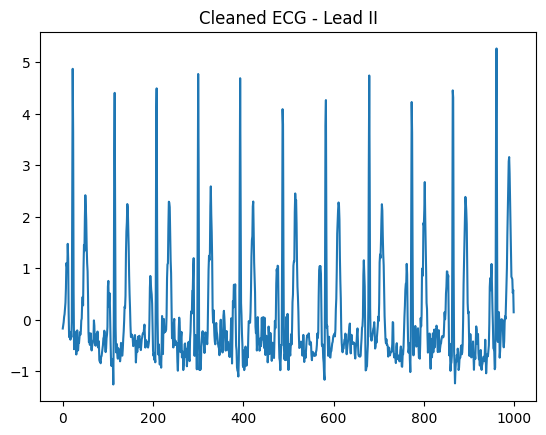

In [9]:

def bandpass_filter(sig, fs=100, low=0.5, high=40):
    nyq = 0.5 * fs
    b, a = butter(4, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

def preprocess(sig, fs=100):
    f = bandpass_filter(sig, fs)
    f -= np.median(f)
    return (f - np.mean(f)) / np.std(f)

ecg_cleaned = preprocess(lead_sig, fs)
plt.plot(ecg_cleaned)
plt.title("Cleaned ECG - Lead II")
plt.show()


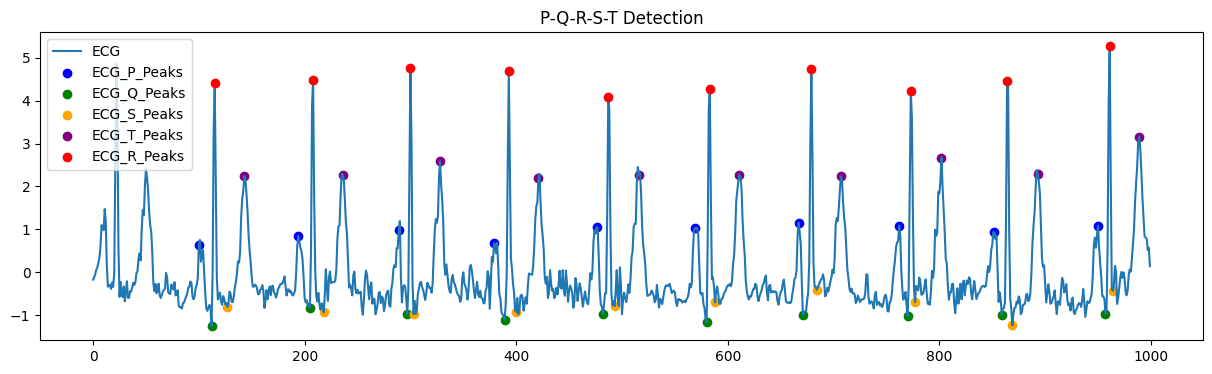

Number of R-peaks detected: 10


In [14]:

_, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
r_peaks = r_info["ECG_R_Peaks"]
signals, waves = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=fs, method="dwt")

plt.figure(figsize=(15,4))
plt.plot(ecg_cleaned, label="ECG")

# ✅ Plot P, Q, S, T peaks (from waves)
for k, c in colors.items():
    if k != "ECG_R_Peaks" and k in waves:
        idx = waves[k]
        plt.scatter(idx, ecg_cleaned[idx], label=k, color=c)

# ✅ Plot R-peaks separately
plt.scatter(r_peaks, ecg_cleaned[r_peaks], color="red", label="ECG_R_Peaks", zorder=5)

plt.legend(loc="upper left")
plt.title("P-Q-R-S-T Detection")
plt.show()

print("Number of R-peaks detected:", len(r_peaks))



In [15]:

def compute_area(signal, start_idx, end_idx):
    return np.trapz(np.abs(signal[start_idx:end_idx])) if end_idx>start_idx else np.nan

def compute_slope(signal, idx1, idx2):
    return (signal[idx2]-signal[idx1])/(idx2-idx1) if idx2>idx1 else np.nan

def measure_st_elevation(signal, j_point, fs=100):
    idx = int(j_point + 0.08*fs)
    baseline = np.mean(signal[:int(0.2*fs)])
    return signal[idx]-baseline if idx<len(signal) else np.nan

def zero_crossings(signal):
    return ((signal[:-1]*signal[1:])<0).sum()


In [16]:

features = {}
Q_on = waves.get("ECG_Q_Onsets", [])
S_off = waves.get("ECG_S_Offsets", [])
P_on = waves.get("ECG_P_Onsets", [])
T_off = waves.get("ECG_T_Offsets", [])
T_on = waves.get("ECG_T_Onsets", [])
T_peaks = waves.get("ECG_T_Peaks", [])
R_pk = r_peaks

rr = np.diff(R_pk)/fs*1000
features['RR_mean'] = np.nanmean(rr)
features['RR_std'] = np.nanstd(rr)
features['HR'] = 60000/features['RR_mean'] if features['RR_mean'] else np.nan

features['QRS_duration'] = np.nanmean([(s-q)/fs*1000 for q,s in zip(Q_on,S_off) if s>q])
features['PR_interval'] = np.nanmean([(q-p)/fs*1000 for p,q in zip(P_on,Q_on) if q>p])
features['QT_interval'] = np.nanmean([(t-q)/fs*1000 for q,t in zip(Q_on,T_off) if t>q])
features['T_duration'] = np.nanmean([(tf-to)/fs*1000 for to,tf in zip(T_on,T_off) if tf>to])

features['R_amp'] = np.nanmax(ecg_cleaned)
features['S_amp'] = np.nanmin(ecg_cleaned)
features['R_S_ratio'] = features['R_amp']/abs(features['S_amp'])
features['Q_amp'] = np.nanmean([ecg_cleaned[q] for q in Q_on if q<len(ecg_cleaned)])
features['QRS_area'] = np.nanmean([compute_area(ecg_cleaned,q,s) for q,s in zip(Q_on,S_off) if s>q])
features['T_amp'] = np.nanmean([ecg_cleaned[t] for t in T_peaks if t<len(ecg_cleaned)])

tasym = []
for to,tf in zip(T_on,T_off):
    if tf>to:
        mid=(to+tf)//2
        su,sd = compute_slope(ecg_cleaned,to,mid),compute_slope(ecg_cleaned,mid,tf)
        if sd!=0: tasym.append(su/abs(sd))
features['T_asymmetry'] = np.nanmean(tasym) if tasym else np.nan

features['ST_elevation'] = np.nanmean([measure_st_elevation(ecg_cleaned,j) for j in S_off])

f,Pxx = welch(ecg_cleaned,fs,nperseg=1024)
bands={'VLF':(0,0.5),'LF':(0.5,4),'MF':(4,15),'HF':(15,40)}
for b,(lo,hi) in bands.items():
    features[f'{b}_power'] = np.trapz(Pxx[(f>=lo)&(f<=hi)],f[(f>=lo)&(f<=hi)])
features['LF_HF_ratio'] = features['LF_power']/features['HF_power'] if features['HF_power']>0 else np.nan
features['dominant_freq'] = f[np.argmax(Pxx)]
Pxx_norm = Pxx/np.sum(Pxx)
features['spectral_entropy'] = -np.sum(Pxx_norm*np.log2(Pxx_norm+1e-10))

features['mean'] = np.mean(ecg_cleaned)
features['median'] = np.median(ecg_cleaned)
features['std'] = np.std(ecg_cleaned)
features['skew'] = skew(ecg_cleaned)
features['kurt'] = kurtosis(ecg_cleaned)
features['zero_crossings'] = zero_crossings(ecg_cleaned)

import pprint
pprint.pprint(features)


{'HF_power': np.float64(0.12052652463645176),
 'HR': np.float64(63.829787234042556),
 'LF_HF_ratio': np.float64(2.576495165027582),
 'LF_power': np.float64(0.3105360079833957),
 'MF_power': np.float64(0.4860901305581512),
 'PR_interval': np.float64(nan),
 'QRS_area': np.float64(nan),
 'QRS_duration': np.float64(nan),
 'QT_interval': np.float64(nan),
 'Q_amp': np.float64(nan),
 'RR_mean': np.float64(940.0),
 'RR_std': np.float64(18.856180831641268),
 'R_S_ratio': np.float64(4.1884514824239725),
 'R_amp': np.float64(5.266167834286229),
 'ST_elevation': np.float64(nan),
 'S_amp': np.float64(-1.2573066338203236),
 'T_amp': np.float64(2.4216634839384534),
 'T_asymmetry': np.float64(0.5285816975479396),
 'T_duration': np.float64(89.0),
 'VLF_power': np.float64(0.0008197049834947673),
 'dominant_freq': np.float64(3.2),
 'kurt': np.float64(5.6002107109572545),
 'mean': np.float64(-1.4210854715202004e-17),
 'median': np.float64(-0.36048499206014534),
 'skew': np.float64(2.214576375040215),
 'sp

C:\Users\Hajel\AppData\Local\Temp\ipykernel_22788\2131149826.py:15: RuntimeWarning: Mean of empty slice
  features['QRS_duration'] = np.nanmean([(s-q)/fs*1000 for q,s in zip(Q_on,S_off) if s>q])
C:\Users\Hajel\AppData\Local\Temp\ipykernel_22788\2131149826.py:16: RuntimeWarning: Mean of empty slice
  features['PR_interval'] = np.nanmean([(q-p)/fs*1000 for p,q in zip(P_on,Q_on) if q>p])
C:\Users\Hajel\AppData\Local\Temp\ipykernel_22788\2131149826.py:17: RuntimeWarning: Mean of empty slice
  features['QT_interval'] = np.nanmean([(t-q)/fs*1000 for q,t in zip(Q_on,T_off) if t>q])
C:\Users\Hajel\AppData\Local\Temp\ipykernel_22788\2131149826.py:23: RuntimeWarning: Mean of empty slice
  features['Q_amp'] = np.nanmean([ecg_cleaned[q] for q in Q_on if q<len(ecg_cleaned)])
C:\Users\Hajel\AppData\Local\Temp\ipykernel_22788\2131149826.py:24: RuntimeWarning: Mean of empty slice
  features['QRS_area'] = np.nanmean([compute_area(ecg_cleaned,q,s) for q,s in zip(Q_on,S_off) if s>q])
C:\Users\Hajel\AppDa

In [ ]:

df = pd.DataFrame([features])
df.to_csv("advanced_ecg_features.csv", index=False)
print("✅ Features saved to advanced_ecg_features.csv")
display(df)
